#[Kaggle Competition](https://www.kaggle.com/c/titanic/data)

##Business understanding

Titanic Machine Learning from Disaster
The sinking of the RMS Titanic is one of the most infamous shipwrecks in history. On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.

One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

In this notebook, I will analyze the data to see what sorts of people were likely to survive. In particular, I will use a decision tree classifier to predict who would likely survive.

##Data Understanding

In [476]:
import matplotlib.pyplot as plt
import numpy as np
import pandas

from sklearn import tree

from sklearn.cross_validation import train_test_split, ShuffleSplit
from sklearn.metrics import confusion_matrix

%matplotlib inline
pandas.options.display.mpl_style = 'default'

In [477]:
filepath = "data/train.csv"
df = pandas.read_csv(filepath)

In [478]:
df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S


In [479]:
df.shape

(891, 12)

There's 890 observations (plus the header) and 12 different variables in this dataset. The dataframe is also not indexed by the PassengerId. So I'll clean up the structure a bit now.

In [480]:
df = df.set_index('PassengerId')

 Before proceeding further it's important to get an understanding of each variable in order to get a sense of what may be important.

From the Kaggle website:

````
======================================
VARIABLE DESCRIPTIONS:
survival        Survival
                (0 = No; 1 = Yes)
pclass          Passenger Class
                (1 = 1st; 2 = 2nd; 3 = 3rd)
name            Name
sex             Sex
age             Age
sibsp           Number of Siblings/Spouses Aboard
parch           Number of Parents/Children Aboard
ticket          Ticket Number
fare            Passenger Fare
cabin           Cabin
embarked        Port of Embarkation
                (C = Cherbourg; Q = Queenstown; S = Southampton)

SPECIAL NOTES:
Pclass is a proxy for socio-economic status (SES)
 1st ~ Upper; 2nd ~ Middle; 3rd ~ Lower

Age is in Years; Fractional if Age less than One (1)
 If the Age is Estimated, it is in the form xx.5

With respect to the family relation variables (i.e. sibsp and parch)
some relations were ignored.  The following are the definitions used
for sibsp and parch.

Sibling:  Brother, Sister, Stepbrother, or Stepsister of Passenger Aboard Titanic
Spouse:   Husband or Wife of Passenger Aboard Titanic (Mistresses and Fiances Ignored)
Parent:   Mother or Father of Passenger Aboard Titanic
Child:    Son, Daughter, Stepson, or Stepdaughter of Passenger Aboard Titanic

Other family relatives excluded from this study include cousins,
nephews/nieces, aunts/uncles, and in-laws.  Some children travelled
only with a nanny, therefore parch=0 for them.  As well, some
travelled with very close friends or neighbors in a village, however,
the definitions do not support such relations.
======================================
````

The variable "survived" is the outcome we want to predict. The idea of "women and children first" was made popular by the Titanic disaster so straight away I know that the person's sex and age will be important for accurate predictions. Additionally wealth people had more clout than poor people in this situation so the class variable will also be a good indicator.

Conversely I think that the person's port of embarkment and ticket number will be completely useless. The ticket fare and cabin type would be good indcators for gauging wealth if we didn't have the pclass explicitly given to us. it may be worth seeing if they line up with each other though.

The remaining variables, namely "sibsp", "parch" are tricky ones. They look into family relation values and thus how much responsbility a person has to their family. This would obviously come into effect for conscientous crew members, who may decide to save an otherwise doomed passenger e.g. a poor man with many children. Perhaps it would weigh even stronger if he didn't have a spouse.

In addition to this quick glance at the data frame, a visualization of the data can also be useful. At http://setosa.io/blog/2014/08/03/csv-fingerprints/ you can paste in a csv file and the app will create an image representing your data and data types.

In [481]:
df.to_csv("output.csv", sep=',')

<img src="images/csv data visualized.png">

The data contains quite a few empty values, these must be addressed before creating a model.

##Data Preparation

Time to check the quality of the data.

In [482]:
df.dtypes

Survived      int64
Pclass        int64
Name         object
Sex          object
Age         float64
SibSp         int64
Parch         int64
Ticket       object
Fare        float64
Cabin        object
Embarked     object
dtype: object

In [483]:
df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [484]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


At first glance the data seems to be very good quality, with only the numerical variable missing some values being Age. 

In [485]:
df.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

"Embarked" also has two missing values. I'm going to make a judgement call and just drop embarked, ticket and cabin from the analysis alltogether.

In [486]:
df = df.drop(['Embarked', 'Ticket','Cabin'], axis=1) 

Time to check is it worth dropping the rows without Age data.

In [487]:
print "{0} rows".format(len(df.index) - df['Age'].isnull().sum())
print "{0}%".format((len(df.index) - df['Age'].isnull().sum()) * 100 / len(df.index))

714 rows
80%


Doing so we would still have 714 rows and 80% of the data which I think is enough to work with for an easy life.

In [488]:
df = df.dropna()

In [489]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare
PassengerId,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,7.2500
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,71.2833
3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,7.9250
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,53.1000
5,0,3,"Allen, Mr. William Henry",male,35,0,0,8.0500


### Exploratory Data Analysis

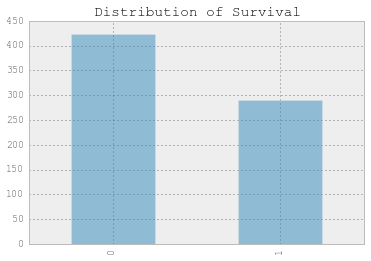

In [490]:
df['Survived'].value_counts().plot(kind='bar', alpha=.5)
plt.title("Distribution of Survival")    

Most of the passengers on board the Titanic died. What are typical characteristics of the deceased?

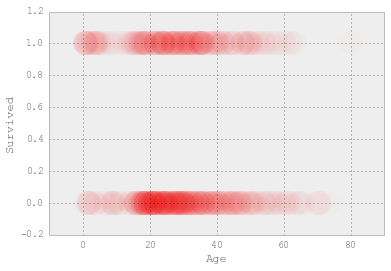

In [491]:
df.plot(kind='scatter', x='Age', y='Survived', s=600, c= "red", alpha =.01, linewidths=.1)

Very young children were more likely to be saved and very old people were less likely.

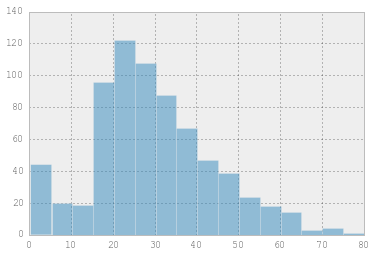

In [492]:
df['Age'].hist(bins=16, alpha=.5)

In [493]:
df['Age'].mean()

29.69911764705882

In [494]:
df['Age'].median()

28.0

The average age for the passengers was about 30 years old. However this is somewhat skewed by a few passengers being over 60 years old. Therefore a more meaningful metric is the median.

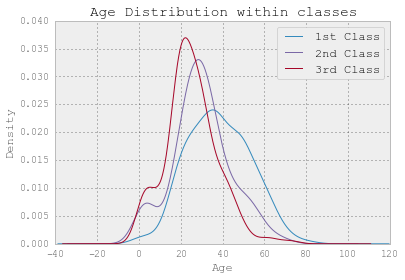

In [495]:
# Plots a kernel density estimate for each class subset.
df['Age'][df['Pclass'] == 1].plot(kind='kde')    
df['Age'][df['Pclass'] == 2].plot(kind='kde')
df['Age'][df['Pclass'] == 3].plot(kind='kde')

# Plots the axes, title, and legend.
plt.xlabel("Age")    
plt.title("Age Distribution within classes")
plt.legend(('1st Class', '2nd Class','3rd Class'), loc='best')

Each distribution is approximately normal. On average the oldest passengers belong to 1st class and the youngest belong to 3rd class. This correlation between age and class should be noted when interpretting any results later on.

In order to work with categorical variables such as sex, it is easier to convert it to a dummy variable (in this case binary will do).

In [496]:
df['Sex'] = df['Sex'].map({'female':0, 'male':1}).astype(int)

Finally, we can remove the name column. It was useful to keep it until now in order to double check any changes we made; especially to ensure that converting the sex feature from string to binary was ok.

In [497]:
df = df.drop("Name", axis=1)

In [498]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
PassengerId,,,,,,,
1,0,3,1,22,1,0,7.2500
2,1,1,0,38,1,0,71.2833
3,1,3,0,26,0,0,7.9250
4,1,1,0,35,1,0,53.1000
5,0,3,1,35,0,0,8.0500


In [499]:
df.shape

(714, 7)

Finally, we have a clean data set ready to be analyzed.

##Modeling

First we remove the column we want to predict from our data. We then select the proportion of the data we want to reserve for testing the model. Then we split up the data and target into training and testing.

In [500]:
# Set the target and drop it from the new df.
target = df['Survived']
data = df.drop("Survived", axis=1)

# Set the proportion of data saved for testing purposes.
proportion = 0.3

# Split the data.
training_data, test_data, training_target, test_target = train_test_split(data, target, random_state=0, test_size=proportion)

### Decision Tree Classifier

I'm going to use a decision tree classifier. This model is relatively simple to set up and very powerful for predicting. There are a number of parameters you can specify for your decision tree, and they mainly focus on preventing the tree from being overfit on the training data and consquently not generalizing well on new data. I've supplied just one extra parameter (number of maximum leafs) in order to get a good balance between bias and variance of the model.

In [501]:
# Initialize a decistion tree classifier and fit it to the training data.
clf = tree.DecisionTreeClassifier(max_leaf_nodes = 7, random_state=0)
clf = clf.fit(training_data, training_target)

# Use the model to predict the testing set's labels.
clf_predictions = clf.predict(test_data)

##Evaluation

After the model has been created it's time to evaluate it's performance on new data that it hasn't been trained on.

In [502]:
# Compare the predictions with the actual labels.
metrics.accuracy_score(test_target, clf_predictions)

0.81395348837209303

An accuracy of 81% is pretty good for a quick model. What does this number specifically mean? It means that the model correctly predicted whether a passenger survived or died in 78% of the test observations. Let's dive deeper into our model to see if there is anything more to see.

In [503]:
confusion_matrix(clf_predictions, test_target)

array([[111,  26],
       [ 14,  64]])

Out of the 125 passengers that actually survived, our model made the correct prediction in 111 cases. Similarly out of the 90 passengers that died, our model correctly predicted 64 of them. This means that our model is better at predicting passengers that died than lived.

## Visualization

In [504]:
tree.export_graphviz(clf, feature_names=data.columns,  out_file='images/tree.dot')  

After exporting the tree to a dot file, you can visualize the data in a number of ways. For this notebook I chose to use http://graphviz-dev.appspot.com for convenience.

<img src="images/tree graph.png">

### Interpreting the graph

The graph is fairly intuitive to interpret. There are a number of nodes, starting from the top of the graph and going down. Each observation goes through the top node and is then passed to the next node based on its values, until it reaches the edge of the graph. Once there, the model decides which class the observation falls under.

The top line of each node shows a feature and value for that feature. If the equation holds, the left branch is chosen for the next node. Otherwise, the right branch. 

The next line is the gini value, which represents the impurity of the node by evaluating how often an observation would be incorrectly labelled if it were randomly labeled according to the distribution of labels in the subset.

Finally the last line represents the number of samples that fall into that node. If the node is a leaf node (i.e. at the edge of the graph) the value represents the probability of the model picking each class.

I'll walk through an example.

In [505]:
df.iloc[[2]]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
PassengerId,,,,,,,
3,1,3,0,26,0,0,7.925


We start at the top of the graph.

Sex <= 0.5 - This parameter separates the females from the males. Since our example adheres to this criteria (0 <= 0.5) we move downwards to the left box.

Pclass <= 2.6 - This parameter checks the passengers class. Our passenger was in Pclass 3 (3rd class) which doesn't meet the criteria so we move straight down.

Fare <= 20.8 - This parameter checks the fare the passenger paid for their ticket. Our value meets this criteria and moves to the left. 

Edge node - this contains an array [25, 30] which means that out of the 55 samples, 25 are likely to be in class 0 (dead) nad 30 are likely to be in class 1 (survived).

While this probabilistic outcome seems like a pointless exercise, it is much better than nodes which contain only one class. This is because it isn't overfitted to the training data and will generalize much better to new data.

However, there are still some edge nodes that reliably lean on way or another, or even definitively classify the observation.

# Conclusion

###"Women and children first"

Judging by the decision tree model it seems like you could get a pretty good accuracy based on just a few intuitive rules. Let's see if this is the case.




In [506]:
# Array to hold predictions.
intuitive_predictions = []

# Loop through the data, parsing class, sex and age from each observation.
for each in test_data:
    pclass, sex, age = each[0], each[1], each[2]
    
    # Survived if female, or < 16 and not 3rd class 
    if (sex == 0) or (age < 16 and pclass != 3):
        intuitive_predictions.append(1)

    else:
        intuitive_predictions.append(0)
            

In [507]:
metrics.accuracy_score(test_target, intuitive_predictions)

0.80000000000000004

Indeed, you could get a good accuracy (only 1% worse than the decision tree classifier!) just based on these 3 criteria and reasonable values. While it may seem that decision tree classifiers aren't very useful because of this, the oppoosite is true. Decision trees are very easy to understand and give us an understanding of the data. Imagine if instead of having such straightforward and small data, you had hundreds of features that you can't give reasonable suggestions for classifier criteria just through your own experience. Decision trees will show you what the main components of the data are. 